In [1]:
# General:
import tweepy
import pandas as pd
import numpy as np

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# For sentiment analysis
from sentimentanalysis import analyze_sentiment, analyze_sentiment_rounded


# We import API keys
from credentials import *   

# the amount of tweets to scrape
AMOUNT_TO_SCRAPE = 50000

In [2]:
def twitter_setup():
    """
    A function to setup the Twitter's API with our own API keys
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

In [3]:
def get_tweets():
    """
    Scrapes all english tweets with keyword, puts all tweet data into a list
    """

    extractor = twitter_setup()

    # Scraping tweets, if rate limit is reached, it will sleep.
    search = tweepy.Cursor(extractor.search, 
                           q = "trump -filter:retweets", 
                           tweet_mode = 'extended', 
                           result_type = "recent", 
                           lang = "en", 
                           wait_on_rate_limit = True, 
                           wait_on_rate_limit_notify = True).items(AMOUNT_TO_SCRAPE)

    # Put all the tweet information into a list
    list_of_tweets = []
    for item in search:
        list_of_tweets.append(item)
    return list_of_tweets



In [4]:
def create_dataframe(tweets):
    """
    Creates a dataframe with all relevant information on the tweet
    """
    # Inserts full tweet into dataFrame (data)
    data = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

    # Adding more information into dataframe

    data['len']  = np.array([len(tweet.full_text) for tweet in tweets])
    data['ID']   = np.array(["twitter.com/user/status/{}".format(tweet.id) for tweet in tweets])
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Source'] = np.array([tweet.source for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

    return data

In [5]:
def analyze(data):
    """
    Calls sentiment analysis function to analyze the sentiment of each tweet
    """
    
    # Adds sentiment analysis (exact) and rounded SA into dataframe
    data['SA'] = np.array([analyze_sentiment(tweet) for tweet in data['Tweets'] ])
    data['Rounded SA'] = np.array([analyze_sentiment_rounded(tweet) for tweet in data['Tweets'] ])
    
    # Displays the dataframe
    display(data.head(AMOUNT_TO_SCRAPE))
    
    return data


In [6]:
def stats(data):
    """
    Prints out information of all scraped tweets including percentage of positive, neutral, negative and average length
    """
    from collections import Counter
    
    # Creates a list of every word in scraped tweets
    all_words = []
    for line in list(data['Tweets']):
        words = line.split()
        for word in words:
            all_words.append(word.lower())
    
    #print(Counter(all_words).most_common(10))

    # Gets the average length of every tweet
    mean = np.mean(data['len'])
    print()
    print("Average length of each tweet: {} characters".format(mean))
    
    
    # Getting percentage of positive, neutral and negative tweets
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]
    
    total_avg_positive = sum( map(len, pos_tweets) ) / len(pos_tweets)
    total_avg_neutral = sum( map(len, neu_tweets) ) / len(neu_tweets)
    total_avg_negative = sum( map(len, neg_tweets) ) / len(neg_tweets)


    print("Average length of each tweet with positive polarity: {} characters".format(total_avg_positive))
    print("Average length of each tweet with neutral polarity: {} characters".format(total_avg_neutral))
    print("Average length of each tweet with negative polarity: {} characters".format(total_avg_negative))
    print()
    
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data['Tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data['Tweets'])))
    print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(data['Tweets'])))
    
    print()
    
    return [total_avg_positive, total_avg_neutral, total_avg_negative]


In [7]:
def most_frequent_words_graph(all_words):
    """
    Is passed in a list of words and creates a plot of the most frequent words
    """
    plt.figure(figsize=(12,5))
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title("Most Frequent Words")
    plt.xticks(fontsize=13, rotation=90)
    fd = nltk.FreqDist(all_words)
    fd.plot(25,cumulative=False)

In [8]:
def filtered_most_frequent_words(all_words):
    """
    Is passed in a list of words, filters them and removes all the words like "hi, ok, I, am, etc" and creates a new list of words
    """
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    import string
    
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt', 'via'] + ['trump', '@realdonaldtrump', 'president']
    
    terms_stop = [term for term in all_words if term not in stop]
    
    most_frequent_words_graph(terms_stop)

In [9]:
def most_frequent_positive_words():
    """
    Filters out words and calls most_frequent_words_graph to creates a plot of the most frequent positive words
    """
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    import string
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] >= 0.4]
    
    pos_words = []
    for line in pos_tweets:
        words = line.split()
        for word in words:
            pos_words.append(word.lower())
    
    punctuation = list(string.punctuation)
    
    stop = stopwords.words('english') + punctuation + ['rt', 'via'] + ['trump', '@realdonaldtrump', 'president']
    
    positive_words = [term for term in pos_words if term not in stop]
    
    most_frequent_words_graph(positive_words)

In [10]:
def most_frequent_negative_words():
    """
    Filters out words and calls most_frequent_words_graph to creates a plot of the most frequent negative words
    """
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    import string
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] <= -0.4]
    
    neg_words = []
    for line in neg_tweets:
        words = line.split()
        for word in words:
            neg_words.append(word.lower())
    
    punctuation = list(string.punctuation)
    
    stop = stopwords.words('english') + punctuation + ['rt', 'via'] + ['trump', '@realdonaldtrump', 'president']
    
    negative_words = [term for term in neg_words if term not in stop]
    
    most_frequent_words_graph(negative_words)

In [11]:
def graph_of_sources(data):
    """
    Is passed in a dataframe and prints out a pie graph of all sources 
    """
    sources = []
    for source in data['Source']:
        if source not in sources:
            sources.append(source)

    # CREATING A PIE GRAPH OF USER CLIENTS
    print()
    print("Pie Graph of User Clients:")

    percent = np.zeros(len(sources))

    for source in data['Source']:
        for index in range(len(sources)):
            if source == sources[index]:
                percent[index] += 1


    # Pie chart:
    pie_chart = pd.Series(percent, index=sources, name='')
    pie_chart.plot.pie(fontsize=20, autopct='%1.1f%%', figsize=(10, 10))
    
    

In [12]:
def graph_of_sources_positive(data):
    """
    Is passed in a dataframe and prints out a pie graph of all sources that have positive SA 
    """
    sources = []
    for source, SA in zip(data["Source"], data["SA"]):
        if SA > 0:
            if source not in sources:
                sources.append(source)
            
    percent = np.zeros(len(sources))
    

    for source in data['Source']:
        for index in range(len(sources)):
            if source == sources[index]:
                percent[index] += 1

    # Pie chart:
    pie_chart = pd.Series(percent, index=sources, name='')
    pie_chart.plot.pie(fontsize=20, autopct='%1.1f%%', figsize=(10, 10))
        

In [13]:
def graph_of_sources_negative(data):
    """
    Is passed in a dataframe and prints out a pie graph of all sources that have positive SA 
    """
    sources = []
    for source, SA in zip(data["Source"], data["SA"]):
        if SA < 0:
            if source not in sources:
                sources.append(source)
            
    percent = np.zeros(len(sources))

    for source in data['Source']:
        for index in range(len(sources)):
            if source == sources[index]:
                percent[index] += 1


    # Pie chart:
    pie_chart = pd.Series(percent, index=sources, name='')
    pie_chart.plot.pie(fontsize=20, autopct='%1.1f%%', figsize=(14, 14))
        

In [14]:
def histogram_of_polarity(data):
    """
    Is passed in a dataframe and prints out a histogram of a range of sentiment
    """
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plot histogram of the polarity values
    data["SA"].hist(ax = ax, color="blue")
    plt.xlabel('Polarity')
    plt.ylabel('Count')
    plt.title("Sentiments from Tweets on Donald Trump")
    plt.show()

In [15]:
def create_time_series(data):
    """
    Is passed in a dataframe and prints out a time series of the length of each tweet at a given time
    """
    print(data['len'].values)
    tlen = pd.Series(data=data['len'].values, index=data['Date'])
    tlen.plot(figsize=(16,4), color='r');


In [16]:
tweets = get_tweets()
dataframe = create_dataframe(tweets) # Creates dataframe from list of tweets
data = analyze(dataframe) # Analyzes data

Rate limit reached. Sleeping for: 430
Rate limit reached. Sleeping for: 866
Rate limit reached. Sleeping for: 865
Rate limit reached. Sleeping for: 864
Rate limit reached. Sleeping for: 868
Rate limit reached. Sleeping for: 867
Rate limit reached. Sleeping for: 866
Rate limit reached. Sleeping for: 864
Rate limit reached. Sleeping for: 866
Rate limit reached. Sleeping for: 864
Rate limit reached. Sleeping for: 868
Rate limit reached. Sleeping for: 864
Rate limit reached. Sleeping for: 867
Rate limit reached. Sleeping for: 867
Rate limit reached. Sleeping for: 866
Rate limit reached. Sleeping for: 867
Rate limit reached. Sleeping for: 865
Rate limit reached. Sleeping for: 868


,Tweets,len,ID,Date,Source,Likes,RTs,SA,Rounded SA
0,@CocoTruth4Trump And that is why Trump is winn...,208,twitter.com/user/status/1106034147615633408,2019-03-14 03:27:44,Twitter for Android,0,0,0.050000,1
1,@einheit @RestiveRabble @MiloB122 @realDonaldT...,346,twitter.com/user/status/1106034147578077185,2019-03-14 03:27:44,Twitter for Android,0,0,0.183333,1
2,@kab_fair @jdawsey1 Bet he was a narcissist fr...,203,twitter.com/user/status/1106034146646872064,2019-03-14 03:27:44,Twitter Web Client,0,0,0.700000,1
3,"Trump: ""Only Rosy o'Donnell"" \nSo who cares wh...",85,twitter.com/user/status/1106034145958989824,2019-03-14 03:27:44,Twitter Web App,0,0,0.000000,0
4,@WIONews @rkelly If his broke how can he affor...,141,twitter.com/user/status/1106034145833164801,2019-03-14 03:27:44,Twitter for iPhone,0,0,0.136364,1
5,"@1013thom Tom, why is it always trying to fool...",279,twitter.com/user/status/1106034144339845120,2019-03-14 03:27:43,Twitter Web Client,0,0,0.355556,1
6,@realDonaldTrump @CarolMariani1 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸...,318,twitter.com/user/status/1106034142310027264,2019-03-14 03:27:43,Twitter for iPhone,0,0,-0.050000,-1
7,@GOP @DonaldJTrumpJr @realDonaldTrump Trump 20...,118,twitter.com/user/status/1106034136932728833,2019-03-14 03:27:42,Twitter for iPhone,0,0,0.000000,0
8,Matt Whitaker ‘blatantly lied to Congress’ — a...,154,twitter.com/user/status/1106034134621683712,2019-03-14 03:27:41,Twitter Web Client,0,0,-0.500000,-1
9,Trump's Proposed Budget Would Devastate Nation...,95,twitter.com/user/status/1106034132558233600,2019-03-14 03:27:40,Twitter for iPhone,0,0,0.000000,0


In [17]:
text_stats = stats(data)


Average length of each tweet: 166.3564 characters
Average length of each tweet with positive polarity: 189.2716372021522 characters
Average length of each tweet with neutral polarity: 118.97350119904077 characters
Average length of each tweet with negative polarity: 191.213763129301 characters

Percentage of positive tweets: 39.03%
Percentage of neutral tweets: 33.36%
Percentage of negative tweets: 27.61%



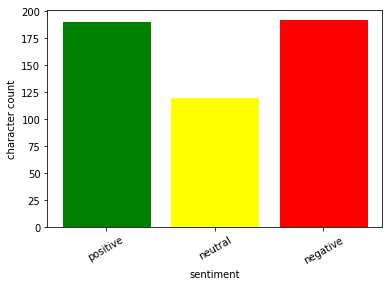

In [51]:

index = np.arange(len(["positive", "negative", "neutral"]))
bar = plt.bar(index, text_stats)
bar[0].set_color('g')
bar[1].set_color('yellow')
bar[2].set_color('r')
plt.xlabel('sentiment', fontsize=10)
plt.ylabel('character count', fontsize=10)
plt.xticks(index, ["positive", "neutral", "negative"], fontsize=10, rotation=30)
plt.show()

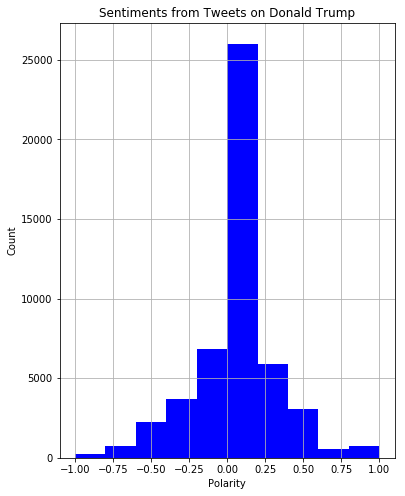

In [19]:
histogram_of_polarity(data)


Pie Graph of User Clients:


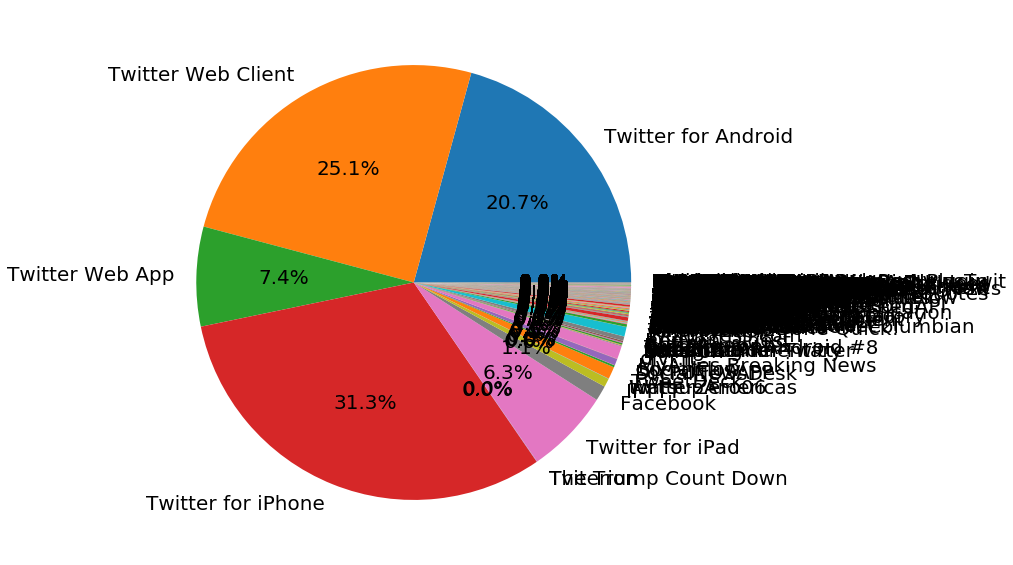

In [20]:
graph_of_sources(data)

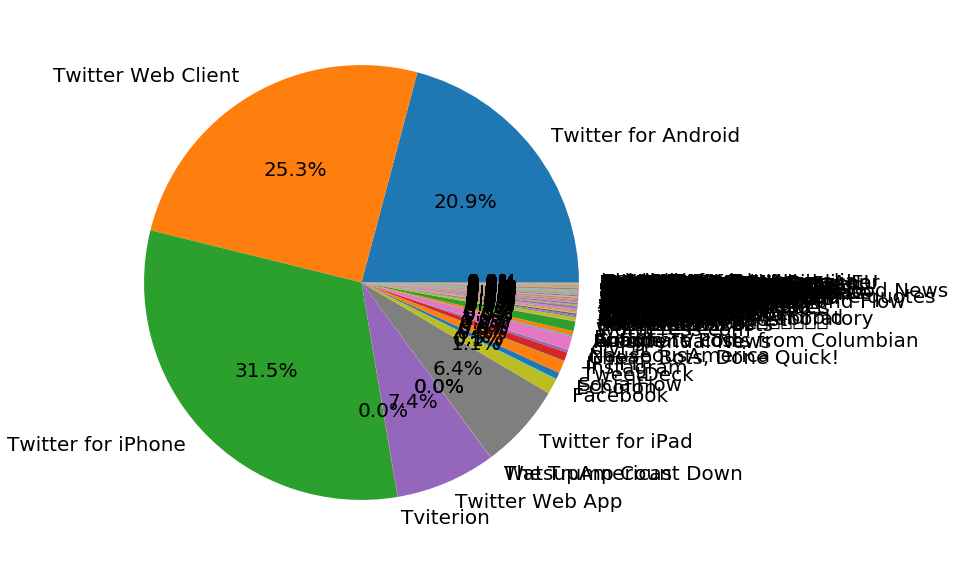

In [21]:
graph_of_sources_positive(data)

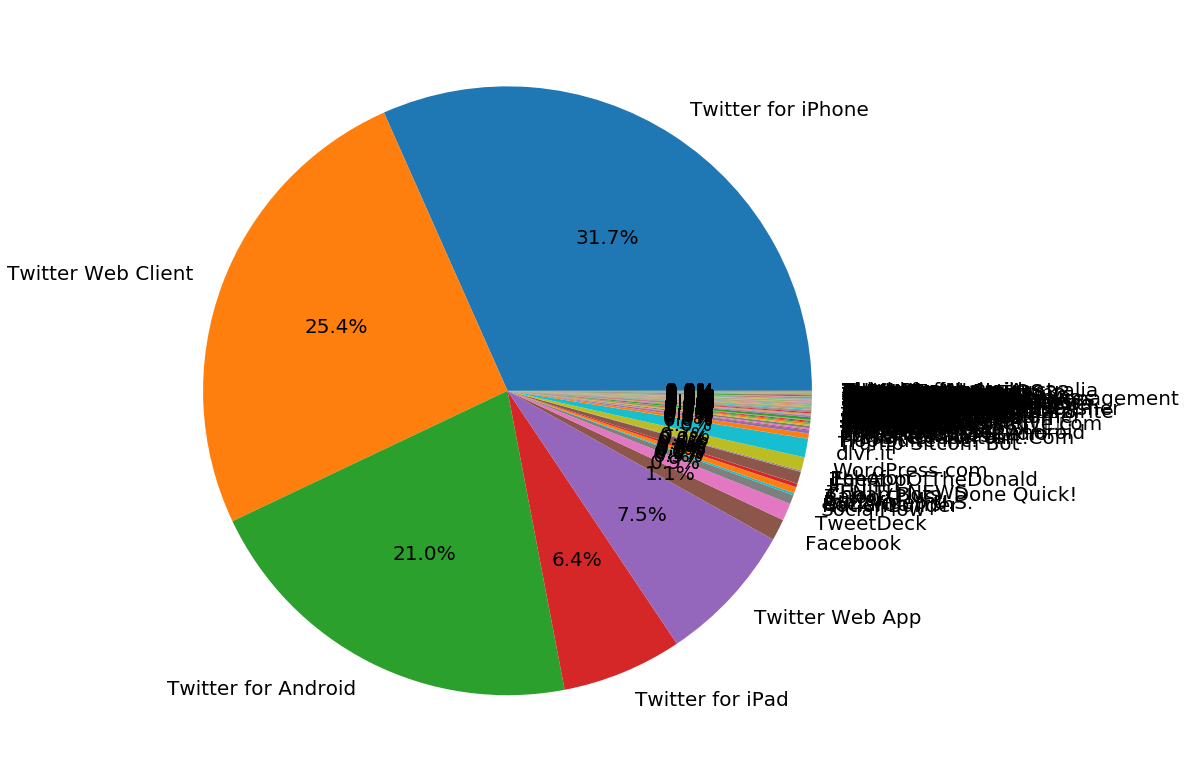

In [22]:
try:
    graph_of_sources_negative(data)
except:
    pass

Most Frequently Used Positive Words (filtered)


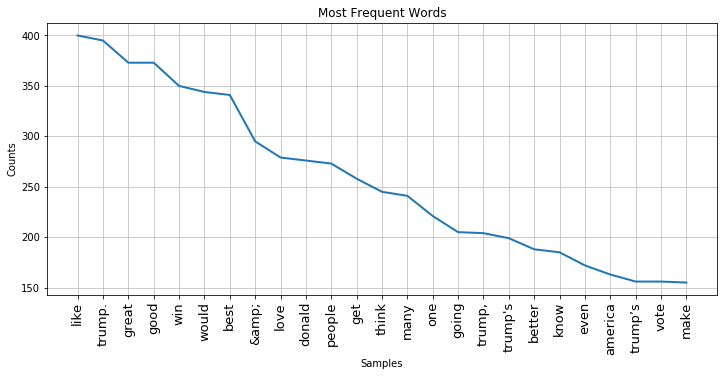

In [25]:
print("Most Frequently Used Positive Words (filtered)")
most_frequent_positive_words()

Most Frequently Used Negative Words (filtered)


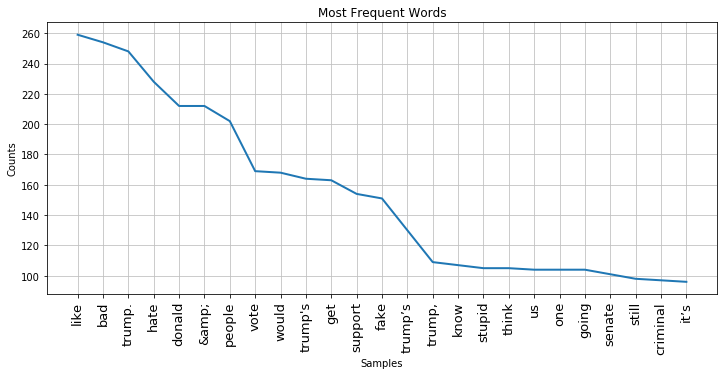

In [26]:
print("Most Frequently Used Negative Words (filtered)")
most_frequent_negative_words()

Time Series of all tweets by length
[208 346 203 ...  97 275  62]


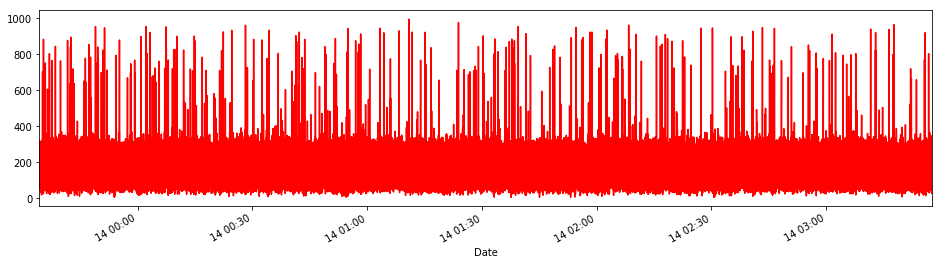

In [27]:
print("Time Series of all tweets by length")
create_time_series(data)

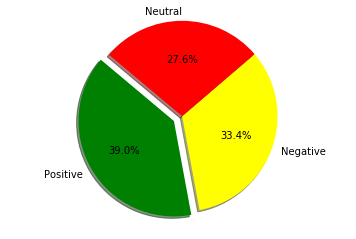

In [45]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Positive', 'Negative', 'Neutral'
sizes = [39.03, 33.36, 27.61]
colors = ['Green', 'Yellow', 'Red']
explode = (0.1, 0, 0) # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 

plt.axis('equal')
plt.show()

#Percentage of positive tweets: 39.03%
#Percentage of neutral tweets: 33.36%
#Percentage of negative tweets: 27.61%

In [ ]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Twitter Web Client', 'Negative', 'Neutral'
sizes = [39.03, 33.36, 27.61]
colors = ['Green', 'Yellow', 'Red']
explode = (0.1, 0, 0) # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 

plt.axis('equal')
plt.show()

#Percentage of positive tweets: 39.03%
#Percentage of neutral tweets: 33.36%
#Percentage of negative tweets: 27.61%